# Overview

## Import Libraries

In [1]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn #neural network
import torchvision as tv
import torchvision.transforms as TF
import torch.optim as optim # optimizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Set Cuda Device and Import Data

In [2]:
# set test device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
index_df = pd.read_csv("../../data/image_index.csv", index_col=0)
index_df.head()

,img,data_set,condition
0,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
1,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
2,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
3,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
4,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0


## Make Train Test Split

In [15]:
index_df['img'] = [img.replace('\\', '/') for img in index_df['img']]

In [16]:
test_df = index_df[index_df.data_set==0]
train_df = index_df[index_df.data_set==1]

In [17]:
train_data = train_df[["img", "condition"]].sample(30, random_state = 42)

In [18]:
y_true = torch.tensor(train_data.condition.values).float()

In [43]:
y_true = torch.tensor(y_true, requires_grad=False)

/Users/danielvalenzuela/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [19]:
img_paths = train_data.img.values

# Second Linear Prototype with Flattened Tensor

In [37]:
class linear_prototype2(nn.Module):
    def __init__(self, img_h, img_w):
        super().__init__()
        #define sizes here
        self.h = img_h
        self.w = img_w
        self.longshape = img_h*img_w
        self.linear1 = nn.Linear(self.longshape, 320)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(320, 2)
        self.softmax = nn.Softmax(dim=0)
    
    def forward(self, x):
        # preprocess the input image
        x = self.preprocess_image_flat(x)
        #============ Layer1==============#
        x = self.linear1(x)
        x = self.relu1(x)
        #============Layer2==============#
        x = self.linear2(x)
        x = self.softmax(x)
        return x
    
    ## update this to sequential?
    def preprocess_image_flat(self, path):
        resizer = TF.Resize((self.h, self.w)) #define resizer per new_h and new_w
        im = tv.io.read_image(path).type(torch.float) #read image as pytorch float tensor
        im = resizer(im) #resize image
        normalizer = TF.Normalize(im.mean(), im.std()) #initialize normalizer
        im = normalizer(im) # return normalized pytorch float tensor
        return torch.flatten(im)

## Optimizer

In [38]:
model = linear_prototype2(640, 640)

In [39]:
criterion = torch.nn.BCELoss(reduction="sum")

In [40]:
def recall_loss(y_true, y_pred):
    answers = list(zip(y_true, y_pred))
    true_positives = sum(1 if (true == 1 and pred == 1) else 0 for true, pred in answers)
    false_negatives = sum(1 if (true == 1 and pred == 0) else 0 for true, pred in answers)
    return torch.tensor(1 - (true_positives/(true_positives + false_negatives)))

In [58]:
def run_optim(n_seq, learning_rate, img_path_list):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(n_seq):
        print(t)
        y_pred = [model(path) for path in img_path_list]
        y_pred = torch.tensor([1 if pred[0] > pred[1] else 0 for pred in y_pred]).float()
        y_pred = y_pred.clone().detach().requires_grad_(True)
        
        print("prediction", y_pred)
        print("true", y_true)
        loss = criterion(y_pred, y_true) #calculate loss

        plt.scatter(t, loss.detach().numpy())
    
        
        optimizer.zero_grad() #reset gradient
        print("it runs upto this line")
        # gradient back step
        loss.backward()
    
        optimizer.step()
        # update parameters per learning rate (go down the gradient)
        with torch.no_grad(): #sequential, no backprop
            for param in model.parameters():
                param += learning_rate * param.grad

In [61]:
for param in model.parameters():
    print(param.grad)

None
None
None
None


0
prediction tensor([1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1.], requires_grad=True)
true tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.])
it runs upto this line


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

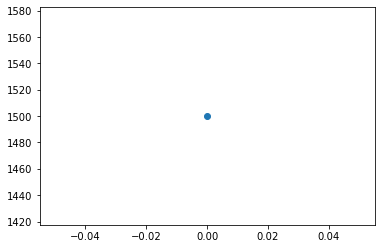

In [60]:
run_optim(5, 0.01, img_paths)

In [291]:
y1 = torch.tensor([1,0,1,1,1,1,1,0,1,1,1,0]).float()
y2 = torch.tensor([1,0,1,1,0,0,1,0,0,1,1,0]).float()


In [293]:

torch.sqrt(torch.mean((y1-y2)**2))

tensor(0.5000)

In [294]:
recall_loss(y1, y2)

tensor(0.3333)

In [207]:
recall_loss(y_true, y_pred)

2
1


0.6666666666666666

In [201]:
y_true = [1, 1, 0, 1, 0]

In [202]:
y_pred = [0, 1, 1, 1, 0]

In [190]:
answer = zip(y_true, y_pred)

In [191]:
true_positive = 0
false_negative = 0

for true, pred in answer:
    print("true", true)
    print("pred", pred)
    if pred == 1 and true == 1:
        true_positive += 1
    elif true == 1 and pred == 0:
        false_negative += 1



true 1
pred 0
true 1
pred 1
true 0
pred 1
true 1
pred 1
true 0
pred 0


In [192]:
true_positive/(false_negative + true_positive)

0.6666666666666666

In [ ]:
def recallhit(cl, pred):
    for x, y in list(zip(cl,pred)):
        if (x == 1) and (y == 1):
            return 1
        elif (x == 1) and y == 0:
            return 1
        else:
            return 0

***


## First Linear Prototype

The issue with this model is that the output is `[1, 640, 2]` when the output should be a shape of `[2,]`. 

A flattening maybe required

In [26]:
class linear_prototype(nn.Module):
    def __init__(self, img_h, img_w):
        super().__init__()
        #define sizes here
        self.h = img_h
        self.w = img_w
        self.linear1 = nn.Linear(img_w, 320)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(320, 2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        # preprocess the input image
        x = self.preprocess_image(x)
        #============ Layer1==============#
        x = self.linear1(x)
        x = self.relu1(x)
        #============Layer2==============#
        x = self.linear2(x)
        
        return self.softmax(x)
    
    ## update this to sequential?
    def preprocess_image(self, path):
        resizer = TF.Resize((self.h, self.w)) #define resizer per new_h and new_w
        im = tv.io.read_image(path).type(torch.float) #read image as pytorch float tensor
        im = resizer(im) #resize image
        normalizer = TF.Normalize(im.mean(), im.std()) #initialize normalizer
        return normalizer(im) # return normalized pytorch float tensor

In [27]:
proto_model = linear_prototype(640, 640)

In [28]:
proto_model

linear_prototype(
  (linear1): Linear(in_features=640, out_features=320, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=320, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [29]:
y_pred = proto_model(test_image_path)

NameError: name 'test_image_path' is not defined

In [113]:
y_pred.shape

torch.Size([1, 640, 2])